# Train

In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

import dask
from torch import nn

from hython.datasets.datasets import LSTMDataset, get_dataset
from hython.trainer import train_val
from hython.sampler import SamplerBuilder
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer


import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR 1: PROJ: proj_create_from_database: Open of /home/iferrario/.local/miniforge/envs/emulator/share/proj failed


# Settings

In [33]:
file_surr_input =  "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_input/adg1km_eobs_preprocessed.zarr/"


surr_model_output = "adg_demo.pt"
experiment = "exp1" # experiment name

dir_surr_output = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model"
dir_stats_output =  "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats"


# === FILTER ==============================================================

# train/test temporal range
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2019-01-01", "2020-12-31")

dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc", "actevap"]

 

# === MASK ========================================================================================

mask_names = ["mask_missing", "mask_lake"] # names depends on preprocessing application

# === DATASET ========================================================================================

dataset = "LSTMDataset"

# == MODEL  ========================================================================================

# DL model hyper parameters
HIDDEN_SIZE = 24
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
OUTPUT_SIZE = len(target_names)
TARGET_WEIGHTS = {t:1/len(target_names) for t in target_names}

# === SAMPLER/TRAINER ===================================================================================

DOWNSAMPLING = False

SEED = 1696
EPOCHS = 20
BATCH = 256
TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = [150, 150] 
SEQ_LENGTH = 60

assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"



In [34]:
set_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
Xd = (
    read_from_zarr(url=file_surr_input, group="xd", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Xs = read_from_zarr(url=file_surr_input, group="xs", multi_index="gridcell").xs.sel(
    feat=static_names
)
Y = (
    read_from_zarr(url=file_surr_input, group="y", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .y.sel(feat=target_names)
)

SHAPE = Xd.attrs["shape"]
# TIME_RANGE = Xd.shape[1]
# print(TIME_RANGE)

# === READ TEST ===================================================================

Y_test = (
    read_from_zarr(url=file_surr_input, group="y", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .y.sel(feat=target_names)
)
Xd_test = (
    read_from_zarr(url=file_surr_input, group="xd", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .xd.sel(feat=dynamic_names)
)

In [36]:
Xd.shape, Y.shape, Y_test.shape, Xd_test.shape

((40140, 1096, 3), (40140, 1096, 3), (40140, 731, 3), (40140, 731, 3))

In [37]:
masks = (
    read_from_zarr(url=file_surr_input, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)

In [38]:
if DOWNSAMPLING:
    train_sampler_builder = SamplerBuilder(sampling_method= "downsampling_regular", 
                                           sampling_method_kwargs = {"intervals": [3,3], "origin": [0, 0]},
                                           minibatch_sampling="random", 
                                           processing="single-gpu")
    
    test_sampler_builder = SamplerBuilder(sampling_method= "downsampling_regular", 
                                          sampling_method_kwargs = {"intervals": [3,3], "origin": [2, 2]}, 
                                          minibatch_sampling="sequential", 
                                          processing="single-gpu")
else:
    train_sampler_builder = SamplerBuilder(sampling_method= "default", 
                                           minibatch_sampling="random", 
                                           processing="single-gpu")
    
    test_sampler_builder = SamplerBuilder(sampling_method= "default", 
                                          minibatch_sampling="sequential", 
                                          processing="single-gpu")

In [39]:
train_sampler_builder.initialize(
    shape=SHAPE, mask_missing=masks.values, 
)
test_sampler_builder.initialize(
    shape=SHAPE, mask_missing=masks.values, 
)

train_sampler = train_sampler_builder.get_sampler()
test_sampler = test_sampler_builder.get_sampler()

found missing
found missing


In [40]:
normalizer_dynamic = Normalizer(method="standardize", type="spacetime", shape="1D")

normalizer_static = Normalizer(method="standardize", type="space", shape="1D")

normalizer_target = Normalizer(method="standardize", type="spacetime", shape="1D")

normalizer_dynamic.compute_stats(Xd[train_sampler_builder.indices])
normalizer_static.compute_stats(Xs[train_sampler_builder.indices])
normalizer_target.compute_stats(Y[train_sampler_builder.indices])

Xd = normalizer_dynamic.normalize(Xd, write_to = f"{dir_stats_output}/{experiment}_xd.npy")
Xs = normalizer_static.normalize(Xs, write_to = f"{dir_stats_output}/{experiment}_xs.npy")
Y = normalizer_target.normalize(Y, write_to = f"{dir_stats_output}/{experiment}_y.npy")

Xd_test = normalizer_dynamic.normalize(Xd_test)
Y_test = normalizer_target.normalize(Y_test)

compute stats
compute stats
compute stats
save stats
save stats
save stats


In [41]:
train_dataset = get_dataset(dataset)(
    torch.Tensor(Xd.values), torch.Tensor(Y.values), torch.Tensor(Xs.values)
)
test_dataset = get_dataset(dataset)(
    torch.Tensor(Xd_test.values),
    torch.Tensor(Y_test.values),
    torch.Tensor(Xs.values),
)

In [42]:
len(train_sampler)

1689

In [43]:
train_loader = DataLoader(train_dataset, batch_size=BATCH , sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH , sampler=test_sampler)

In [44]:
model = CuDNNLSTM(
                  hidden_size=HIDDEN_SIZE, 
                  dynamic_input_size=DYNAMIC_INPUT_SIZE,
                  static_input_size=STATIC_INPUT_SIZE, 
                  output_size=OUTPUT_SIZE
)

In [45]:
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

In [46]:
loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)
metric_fn = MSEMetric(target_names=target_names)

In [47]:
trainer = RNNTrainer(
    RNNTrainParams(
               experiment=experiment, 
               temporal_subsampling=TEMPORAL_SUBSAMPLING, 
               temporal_subset=TEMPORAL_SUBSET, 
               seq_length=SEQ_LENGTH, 
               target_names=target_names,
               metric_func=metric_fn,
               loss_func=loss_fn)
)

In [48]:
file_surr_output = f"{dir_surr_output}/{experiment}_{surr_model_output}"

In [49]:
# train
model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    test_loader,
    EPOCHS,
    opt,
    lr_scheduler,
    file_surr_output,
    device
)

  5%|████▊                                                                                            | 1/20 [00:04<01:18,  4.14s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_adg_demo.pt
Copied best model weights!
train loss: 0.27190104126930237
val loss: 0.28272998332977295


 10%|█████████▋                                                                                       | 2/20 [00:08<01:12,  4.04s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_adg_demo.pt
Copied best model weights!
train loss: 0.22554408013820648
val loss: 0.2765767574310303


 15%|██████████████▌                                                                                  | 3/20 [00:12<01:08,  4.03s/it]

train loss: 0.2154378592967987
val loss: 0.28039872646331787


 20%|███████████████████▍                                                                             | 4/20 [00:16<01:04,  4.01s/it]

train loss: 0.2105390578508377
val loss: 0.3037084639072418


 25%|████████████████████████▎                                                                        | 5/20 [00:20<00:59,  3.97s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_adg_demo.pt
Copied best model weights!
train loss: 0.1896706372499466
val loss: 0.2702561914920807


 30%|█████████████████████████████                                                                    | 6/20 [00:24<00:56,  4.02s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_adg_demo.pt
Copied best model weights!
train loss: 0.18884672224521637
val loss: 0.2540423572063446


 35%|█████████████████████████████████▉                                                               | 7/20 [00:28<00:52,  4.00s/it]

train loss: 0.19908340275287628
val loss: 0.2836713492870331


 40%|██████████████████████████████████████▊                                                          | 8/20 [00:31<00:47,  3.96s/it]

train loss: 0.18264353275299072
val loss: 0.2794843912124634


 45%|███████████████████████████████████████████▋                                                     | 9/20 [00:35<00:43,  3.94s/it]

train loss: 0.19617195427417755
val loss: 0.28589367866516113


 50%|████████████████████████████████████████████████                                                | 10/20 [00:39<00:39,  3.94s/it]

train loss: 0.18686917424201965
val loss: 0.2611234784126282


 55%|████████████████████████████████████████████████████▊                                           | 11/20 [00:43<00:35,  3.96s/it]

train loss: 0.17350491881370544
val loss: 0.2541849911212921


 60%|█████████████████████████████████████████████████████████▌                                      | 12/20 [00:47<00:31,  3.97s/it]

train loss: 0.1844490021467209
val loss: 0.26304543018341064


 65%|██████████████████████████████████████████████████████████████▍                                 | 13/20 [00:51<00:27,  3.99s/it]

train loss: 0.1793690174818039
val loss: 0.2756561040878296


 70%|███████████████████████████████████████████████████████████████████▏                            | 14/20 [00:55<00:23,  3.98s/it]

train loss: 0.18061403930187225
val loss: 0.2612951695919037


 75%|████████████████████████████████████████████████████████████████████████                        | 15/20 [00:59<00:19,  3.99s/it]

train loss: 0.1832467019557953
val loss: 0.2542165219783783


 80%|████████████████████████████████████████████████████████████████████████████▊                   | 16/20 [01:03<00:16,  4.00s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_adg_demo.pt
Copied best model weights!
train loss: 0.17254960536956787
val loss: 0.250811904668808


 85%|█████████████████████████████████████████████████████████████████████████████████▌              | 17/20 [01:07<00:11,  3.99s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_adg_demo.pt
Copied best model weights!
train loss: 0.18704381585121155
val loss: 0.2503754496574402


 90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 18/20 [01:11<00:07,  3.99s/it]

train loss: 0.1780124306678772
val loss: 0.2694571018218994


 95%|███████████████████████████████████████████████████████████████████████████████████████████▏    | 19/20 [01:15<00:04,  4.01s/it]

train loss: 0.17512035369873047
val loss: 0.25928646326065063


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.99s/it]

train loss: 0.17199082672595978
val loss: 0.26897913217544556


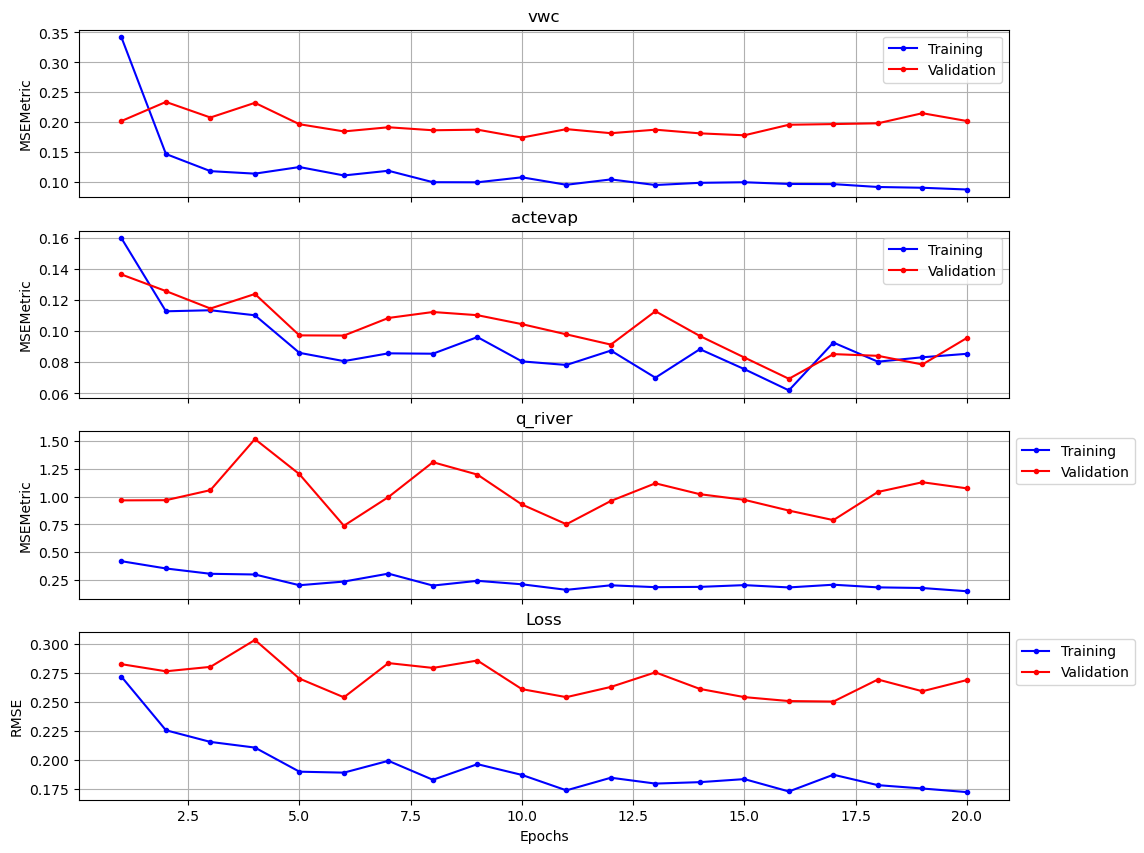

In [50]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(len(target_names) +1, 1, figsize= (12,10), sharex=True)

for i, variable in enumerate(target_names):
    axs[i].plot(lepochs, metric_history[f'train_{variable}'], marker='.', linestyle='-', color='b', label='Training')
    axs[i].plot(lepochs, metric_history[f'val_{variable}'], marker='.', linestyle='-', color='r', label='Validation')
    axs[i].set_title(variable)
    axs[i].set_ylabel(metric_fn.__class__.__name__)
    axs[i].grid(True)
    axs[i].legend(bbox_to_anchor=(1,1))

axs[i+1].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[i+1].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[i+1].set_title('Loss')
axs[i+1].set_xlabel('Epochs')
axs[i+1].set_ylabel(loss_fn.__name__)
axs[i+1].grid(True)
axs[i+1].legend(bbox_to_anchor=(1,1))